In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_squared_error 
from math import sqrt 
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt, adfuller
import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.tsa.arima_model import ARIMA

In [2]:
train = pd.read_csv('./data/TrainData.csv')
test = pd.read_csv('./data/TestData.csv')

In [3]:
train.isnull().sum()

ID          0
Datetime    0
Count       0
dtype: int64

In [4]:
test.isnull().sum()

ID          0
Datetime    0
dtype: int64

In [5]:
train_org = train.copy()
test_org = test.copy()

In [6]:
train.columns

Index(['ID', 'Datetime', 'Count'], dtype='object')

In [7]:
test.columns

Index(['ID', 'Datetime'], dtype='object')

In [8]:
train.Datetime.head(10)

0    25-08-2012 00:00
1    25-08-2012 01:00
2    25-08-2012 02:00
3    25-08-2012 03:00
4    25-08-2012 04:00
5    25-08-2012 05:00
6    25-08-2012 06:00
7    25-08-2012 07:00
8    25-08-2012 08:00
9    25-08-2012 09:00
Name: Datetime, dtype: object

In [9]:
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M')
test_org['Datetime'] = pd.to_datetime(test_org.Datetime,format='%d-%m-%Y %H:%M')
train_org['Datetime'] = pd.to_datetime(train_org.Datetime,format='%d-%m-%Y %H:%M')

In [10]:

train.Datetime.head(10)

0   2012-08-25 00:00:00
1   2012-08-25 01:00:00
2   2012-08-25 02:00:00
3   2012-08-25 03:00:00
4   2012-08-25 04:00:00
5   2012-08-25 05:00:00
6   2012-08-25 06:00:00
7   2012-08-25 07:00:00
8   2012-08-25 08:00:00
9   2012-08-25 09:00:00
Name: Datetime, dtype: datetime64[ns]

In [11]:
for i in (train,test):
    i['year']=i.Datetime.dt.year 
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour

In [12]:
train['dayOfWeek'] = train['Datetime'].dt.dayofweek

In [13]:
train.head(25)

,ID,Datetime,Count,year,month,day,Hour,dayOfWeek
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5
5,5,2012-08-25 05:00:00,2,2012,8,25,5,5
6,6,2012-08-25 06:00:00,2,2012,8,25,6,5
7,7,2012-08-25 07:00:00,2,2012,8,25,7,5
8,8,2012-08-25 08:00:00,6,2012,8,25,8,5
9,9,2012-08-25 09:00:00,2,2012,8,25,9,5


In [14]:
def weekend(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0

In [15]:
train['weekend'] = train.Datetime.apply(weekend)

In [16]:
train.head(10)

,ID,Datetime,Count,year,month,day,Hour,dayOfWeek,weekend
0,0,2012-08-25 00:00:00,8,2012,8,25,0,5,1
1,1,2012-08-25 01:00:00,2,2012,8,25,1,5,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2,5,1
3,3,2012-08-25 03:00:00,2,2012,8,25,3,5,1
4,4,2012-08-25 04:00:00,2,2012,8,25,4,5,1
5,5,2012-08-25 05:00:00,2,2012,8,25,5,5,1
6,6,2012-08-25 06:00:00,2,2012,8,25,6,5,1
7,7,2012-08-25 07:00:00,2,2012,8,25,7,5,1
8,8,2012-08-25 08:00:00,6,2012,8,25,8,5,1
9,9,2012-08-25 09:00:00,2,2012,8,25,9,5,1


In [17]:
train.set_index('Datetime',inplace=True)
train.drop('ID',axis=1,inplace=True)

In [18]:
train.head(10)

,Count,year,month,day,Hour,dayOfWeek,weekend
Datetime,,,,,,,
2012-08-25 00:00:00,8,2012,8,25,0,5,1
2012-08-25 01:00:00,2,2012,8,25,1,5,1
2012-08-25 02:00:00,6,2012,8,25,2,5,1
2012-08-25 03:00:00,2,2012,8,25,3,5,1
2012-08-25 04:00:00,2,2012,8,25,4,5,1
2012-08-25 05:00:00,2,2012,8,25,5,5,1
2012-08-25 06:00:00,2,2012,8,25,6,5,1
2012-08-25 07:00:00,2,2012,8,25,7,5,1
2012-08-25 08:00:00,6,2012,8,25,8,5,1


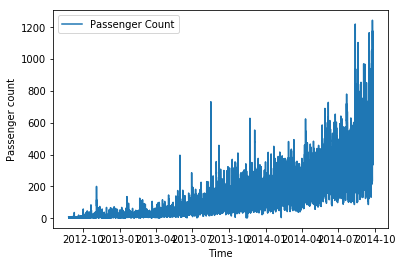

In [19]:
plt.plot(train['Count'],label = 'Passenger Count')
plt.xlabel("Time") 
plt.ylabel("Passenger count") 
plt.legend(loc='best')

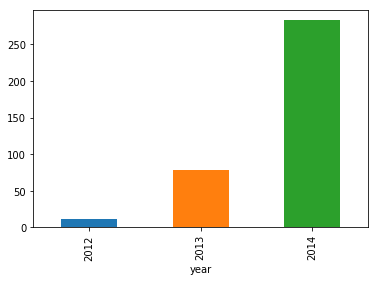

In [20]:
# Year Wise
train.groupby('year')['Count'].mean().plot.bar()

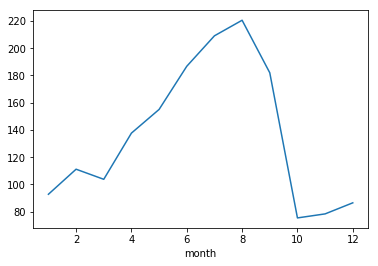

In [21]:
# Month Wise
train.groupby('month')['Count'].mean().plot()

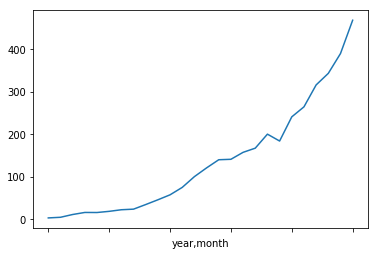

In [22]:
# Year & Month wise
train.groupby(['year','month'])['Count'].mean().plot()

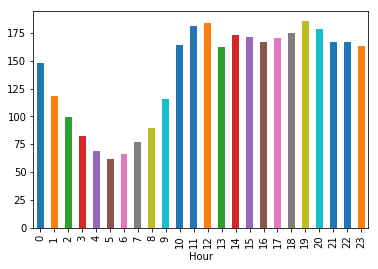

In [23]:
# Hour wise
train.groupby('Hour')['Count'].mean().plot.bar()

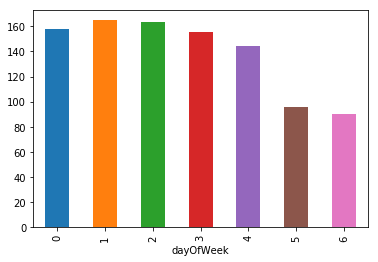

In [24]:
train.groupby('dayOfWeek')['Count'].mean().plot.bar()

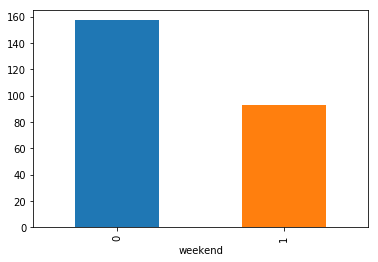

In [25]:
train.groupby('weekend')['Count'].mean().plot.bar()

In [26]:
# Resampling data
hourly = train.resample('H').mean() 
daily = train.resample('D').mean()  
weekly = train.resample('W').mean() 
monthly = train.resample('M').mean()

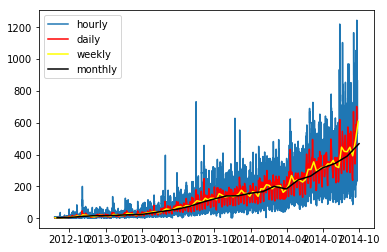

In [27]:
plt.plot(hourly['Count'])
plt.plot(daily['Count'],color='red')
plt.plot(weekly['Count'],color='yellow')
plt.plot(monthly['Count'],color='black')
plt.legend(['hourly','daily','weekly','monthly'])

In [28]:
train = train.resample('D').mean()

In [29]:
test.set_index('Datetime',inplace=True)
test.drop('ID',axis=1,inplace=True)
test = test.resample('D').mean()

In [30]:
# Split the data
training=train.loc['2012-08-25':'2014-06-24'] 
validating=train.loc['2014-06-25':'2014-09-25']

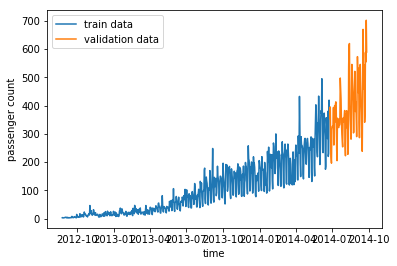

In [31]:
plt.plot(training['Count'])
plt.plot(validating['Count'])
plt.xlabel('time')
plt.ylabel('passenger count')
plt.legend(['train data','validation data'])

In [32]:
# Forecasting and validating
arr = np.asarray(training.Count)

pred = validating.copy()

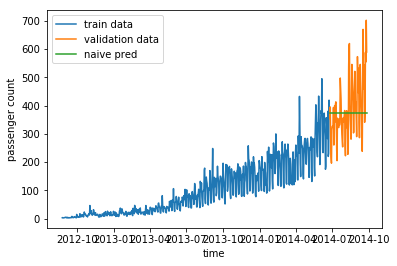

In [33]:
# Naive prediction
pred['naive'] = arr[arr.shape[0]-1]

plt.plot(training['Count'])
plt.plot(validating['Count'])
plt.plot(pred['naive'])
plt.xlabel('time')
plt.ylabel('passenger count')
plt.legend(['train data','validation data','naive pred'])

In [34]:
rmse = sqrt(mean_squared_error(validating.Count, pred.naive)) 
print("RMSE SCORE:",rmse)

RMSE SCORE: 111.79050467496724


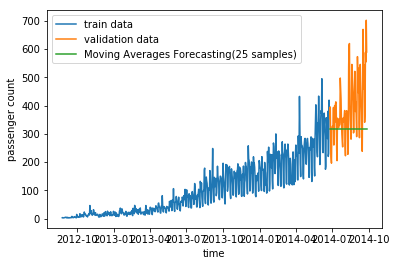

In [35]:
# Moving Averages Forecasting
pred['MAF'] = training['Count'].rolling(25).mean().iloc[-1]

plt.plot(training['Count'])
plt.plot(validating['Count'])
plt.plot(pred['MAF'])
plt.xlabel('time')
plt.ylabel('passenger count')
plt.legend(['train data','validation data','Moving Averages Forecasting(25 samples)'])

In [36]:
rmse = sqrt(mean_squared_error(validating.Count, pred.MAF)) 
print("RMSE SCORE:",rmse)

RMSE SCORE: 132.25462585292883


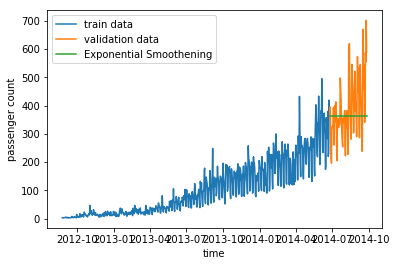

In [37]:
# Exponential Smoothening
pred['ES'] = SimpleExpSmoothing(np.asarray(training['Count'])).fit(smoothing_level=0.6,optimized=False).forecast(len(validating))

plt.plot(training['Count'])
plt.plot(validating['Count'])
plt.plot(pred['ES'])
plt.xlabel('time')
plt.ylabel('passenger count')
plt.legend(['train data','validation data','Exponential Smoothening'])

In [38]:
rmse = sqrt(mean_squared_error(validating.Count, pred.ES)) 
print("RMSE SCORE:",rmse)

RMSE SCORE: 113.43708111884514


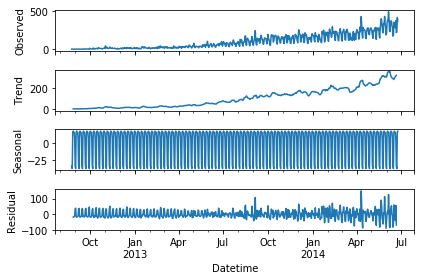

In [39]:
# Holt's Linear Forecasting
sm.tsa.seasonal_decompose(training.Count).plot() 
result = sm.tsa.stattools.adfuller(training.Count) 
plt.show()

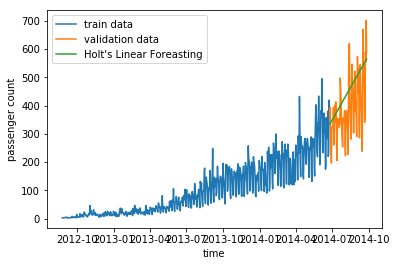

In [40]:
pred['HLF'] = Holt(arr).fit(smoothing_level = 0.3,smoothing_slope = 0.1).forecast(len(validating))

plt.plot(training['Count'])
plt.plot(validating['Count'])
plt.plot(pred['HLF'])
plt.xlabel('time')
plt.ylabel('passenger count')
plt.legend(['train data','validation data',"Holt's Linear Foreasting"])

In [41]:
rmse = sqrt(mean_squared_error(validating.Count, pred.HLF)) 
print("RMSE SCORE:",rmse)

RMSE SCORE: 112.94278345314041


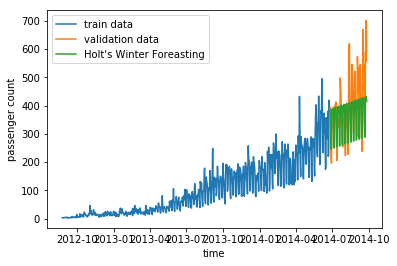

In [42]:
# Holt's Winter Forecasting
model = ExponentialSmoothing(arr,seasonal_periods=7 ,trend='add', seasonal='add').fit()
pred['HWF'] = model.forecast(len(validating))

plt.plot(training['Count'])
plt.plot(validating['Count'])
plt.plot(pred['HWF'])
plt.xlabel('time')
plt.ylabel('passenger count')
plt.legend(['train data','validation data',"Holt's Winter Foreasting"])

In [43]:
rmse = sqrt(mean_squared_error(validating.Count, pred.HWF)) 
print("RMSE SCORE:",rmse)

RMSE SCORE: 82.37467736825413


In [44]:
# Forecast on test data
test['pred_HWF'] = model.forecast(len(test))
test.head(10)

,year,month,day,Hour,pred_HWF
Datetime,,,,,
2014-09-26,2014.0,9.0,26.0,11.5,387.359889
2014-09-27,2014.0,9.0,27.0,11.5,369.136159
2014-09-28,2014.0,9.0,28.0,11.5,355.562755
2014-09-29,2014.0,9.0,29.0,11.5,247.090305
2014-09-30,2014.0,9.0,30.0,11.5,246.193987
2014-10-01,2014.0,10.0,1.0,11.5,385.878962
2014-10-02,2014.0,10.0,2.0,11.5,376.802422
2014-10-03,2014.0,10.0,3.0,11.5,390.854125
2014-10-04,2014.0,10.0,4.0,11.5,372.630395


In [45]:
test_org.head(10)

,ID,Datetime
0,18288,2014-09-26 00:00:00
1,18289,2014-09-26 01:00:00
2,18290,2014-09-26 02:00:00
3,18291,2014-09-26 03:00:00
4,18292,2014-09-26 04:00:00
5,18293,2014-09-26 05:00:00
6,18294,2014-09-26 06:00:00
7,18295,2014-09-26 07:00:00
8,18296,2014-09-26 08:00:00
9,18297,2014-09-26 09:00:00


In [46]:
train_org.head(10)

,ID,Datetime,Count
0,0,2012-08-25 00:00:00,8
1,1,2012-08-25 01:00:00,2
2,2,2012-08-25 02:00:00,6
3,3,2012-08-25 03:00:00,2
4,4,2012-08-25 04:00:00,2
5,5,2012-08-25 05:00:00,2
6,6,2012-08-25 06:00:00,2
7,7,2012-08-25 07:00:00,2
8,8,2012-08-25 08:00:00,6
9,9,2012-08-25 09:00:00,2


In [47]:
# Ratio of each hour of everyday on train data
train_org['ratio']=train_org['Count']/train_org['Count'].sum()

train_org.head(10)

,ID,Datetime,Count,ratio
0,0,2012-08-25 00:00:00,8,3.148037e-06
1,1,2012-08-25 01:00:00,2,7.870093e-07
2,2,2012-08-25 02:00:00,6,2.361028e-06
3,3,2012-08-25 03:00:00,2,7.870093e-07
4,4,2012-08-25 04:00:00,2,7.870093e-07
5,5,2012-08-25 05:00:00,2,7.870093e-07
6,6,2012-08-25 06:00:00,2,7.870093e-07
7,7,2012-08-25 07:00:00,2,7.870093e-07
8,8,2012-08-25 08:00:00,6,2.361028e-06
9,9,2012-08-25 09:00:00,2,7.870093e-07


In [48]:
train_org.dtypes

ID                   int64
Datetime    datetime64[ns]
Count                int64
ratio              float64
dtype: object

In [49]:
for i in (train_org,test_org):
    i['year']=i.Datetime.dt.year 
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour
    
train_org.head(24)

,ID,Datetime,Count,ratio,year,month,day,Hour
0,0,2012-08-25 00:00:00,8,3.148037e-06,2012,8,25,0
1,1,2012-08-25 01:00:00,2,7.870093e-07,2012,8,25,1
2,2,2012-08-25 02:00:00,6,2.361028e-06,2012,8,25,2
3,3,2012-08-25 03:00:00,2,7.870093e-07,2012,8,25,3
4,4,2012-08-25 04:00:00,2,7.870093e-07,2012,8,25,4
5,5,2012-08-25 05:00:00,2,7.870093e-07,2012,8,25,5
6,6,2012-08-25 06:00:00,2,7.870093e-07,2012,8,25,6
7,7,2012-08-25 07:00:00,2,7.870093e-07,2012,8,25,7
8,8,2012-08-25 08:00:00,6,2.361028e-06,2012,8,25,8
9,9,2012-08-25 09:00:00,2,7.870093e-07,2012,8,25,9


In [50]:
groupbydf = pd.DataFrame(train_org.groupby('Hour')['ratio'].sum())

groupbydf

,ratio
Hour,
0,0.044287
1,0.035343
2,0.029911
3,0.024714
4,0.020802
5,0.018621
6,0.020023
7,0.023221
8,0.026741


In [51]:
# Make foreacsting feasible on test data

finalTestPred = pd.merge(test, test_org, on=('day','month', 'year'), how='left')
finalTestPred.head(10)

,year,month,day,Hour_x,pred_HWF,ID,Datetime,Hour_y
0,2014.0,9.0,26.0,11.5,387.359889,18288,2014-09-26 00:00:00,0
1,2014.0,9.0,26.0,11.5,387.359889,18289,2014-09-26 01:00:00,1
2,2014.0,9.0,26.0,11.5,387.359889,18290,2014-09-26 02:00:00,2
3,2014.0,9.0,26.0,11.5,387.359889,18291,2014-09-26 03:00:00,3
4,2014.0,9.0,26.0,11.5,387.359889,18292,2014-09-26 04:00:00,4
5,2014.0,9.0,26.0,11.5,387.359889,18293,2014-09-26 05:00:00,5
6,2014.0,9.0,26.0,11.5,387.359889,18294,2014-09-26 06:00:00,6
7,2014.0,9.0,26.0,11.5,387.359889,18295,2014-09-26 07:00:00,7
8,2014.0,9.0,26.0,11.5,387.359889,18296,2014-09-26 08:00:00,8
9,2014.0,9.0,26.0,11.5,387.359889,18297,2014-09-26 09:00:00,9


In [52]:
finalTestPred['Hour'] = finalTestPred['Hour_y']
finalTestPred.head(10)

,year,month,day,Hour_x,pred_HWF,ID,Datetime,Hour_y,Hour
0,2014.0,9.0,26.0,11.5,387.359889,18288,2014-09-26 00:00:00,0,0
1,2014.0,9.0,26.0,11.5,387.359889,18289,2014-09-26 01:00:00,1,1
2,2014.0,9.0,26.0,11.5,387.359889,18290,2014-09-26 02:00:00,2,2
3,2014.0,9.0,26.0,11.5,387.359889,18291,2014-09-26 03:00:00,3,3
4,2014.0,9.0,26.0,11.5,387.359889,18292,2014-09-26 04:00:00,4,4
5,2014.0,9.0,26.0,11.5,387.359889,18293,2014-09-26 05:00:00,5,5
6,2014.0,9.0,26.0,11.5,387.359889,18294,2014-09-26 06:00:00,6,6
7,2014.0,9.0,26.0,11.5,387.359889,18295,2014-09-26 07:00:00,7,7
8,2014.0,9.0,26.0,11.5,387.359889,18296,2014-09-26 08:00:00,8,8
9,2014.0,9.0,26.0,11.5,387.359889,18297,2014-09-26 09:00:00,9,9


In [53]:
finalTestPred=finalTestPred.drop(['year', 'month','Hour_x','Hour_y'], axis=1)
finalTestPred.head(10)

,day,pred_HWF,ID,Datetime,Hour
0,26.0,387.359889,18288,2014-09-26 00:00:00,0
1,26.0,387.359889,18289,2014-09-26 01:00:00,1
2,26.0,387.359889,18290,2014-09-26 02:00:00,2
3,26.0,387.359889,18291,2014-09-26 03:00:00,3
4,26.0,387.359889,18292,2014-09-26 04:00:00,4
5,26.0,387.359889,18293,2014-09-26 05:00:00,5
6,26.0,387.359889,18294,2014-09-26 06:00:00,6
7,26.0,387.359889,18295,2014-09-26 07:00:00,7
8,26.0,387.359889,18296,2014-09-26 08:00:00,8
9,26.0,387.359889,18297,2014-09-26 09:00:00,9


In [54]:
finalTestPred = pd.merge(finalTestPred,groupbydf,on='Hour',how='left')
finalTestPred.head(10)

,day,pred_HWF,ID,Datetime,Hour,ratio
0,26.0,387.359889,18288,2014-09-26 00:00:00,0,0.044287
1,26.0,387.359889,18289,2014-09-26 01:00:00,1,0.035343
2,26.0,387.359889,18290,2014-09-26 02:00:00,2,0.029911
3,26.0,387.359889,18291,2014-09-26 03:00:00,3,0.024714
4,26.0,387.359889,18292,2014-09-26 04:00:00,4,0.020802
5,26.0,387.359889,18293,2014-09-26 05:00:00,5,0.018621
6,26.0,387.359889,18294,2014-09-26 06:00:00,6,0.020023
7,26.0,387.359889,18295,2014-09-26 07:00:00,7,0.023221
8,26.0,387.359889,18296,2014-09-26 08:00:00,8,0.026741
9,26.0,387.359889,18297,2014-09-26 09:00:00,9,0.034555


In [55]:
finalTestPred['Count'] = finalTestPred['pred_HWF']*finalTestPred['ratio']*24
finalTestPred.head(10)

,day,pred_HWF,ID,Datetime,Hour,ratio,Count
0,26.0,387.359889,18288,2014-09-26 00:00:00,0,0.044287,411.716346
1,26.0,387.359889,18289,2014-09-26 01:00:00,1,0.035343,328.571184
2,26.0,387.359889,18290,2014-09-26 02:00:00,2,0.029911,278.072424
3,26.0,387.359889,18291,2014-09-26 03:00:00,3,0.024714,229.761310
4,26.0,387.359889,18292,2014-09-26 04:00:00,4,0.020802,193.390789
5,26.0,387.359889,18293,2014-09-26 05:00:00,5,0.018621,173.116656
6,26.0,387.359889,18294,2014-09-26 06:00:00,6,0.020023,186.147414
7,26.0,387.359889,18295,2014-09-26 07:00:00,7,0.023221,215.881833
8,26.0,387.359889,18296,2014-09-26 08:00:00,8,0.026741,248.601400
9,26.0,387.359889,18297,2014-09-26 09:00:00,9,0.034555,321.247327


In [56]:
finalTestPred.drop(['day','pred_HWF','Hour','ratio'],axis=1,inplace=True)
finalTestPred

,ID,Datetime,Count
0,18288,2014-09-26 00:00:00,411.716346
1,18289,2014-09-26 01:00:00,328.571184
2,18290,2014-09-26 02:00:00,278.072424
3,18291,2014-09-26 03:00:00,229.761310
4,18292,2014-09-26 04:00:00,193.390789
5,18293,2014-09-26 05:00:00,173.116656
6,18294,2014-09-26 06:00:00,186.147414
7,18295,2014-09-26 07:00:00,215.881833
8,18296,2014-09-26 08:00:00,248.601400
9,18297,2014-09-26 09:00:00,321.247327


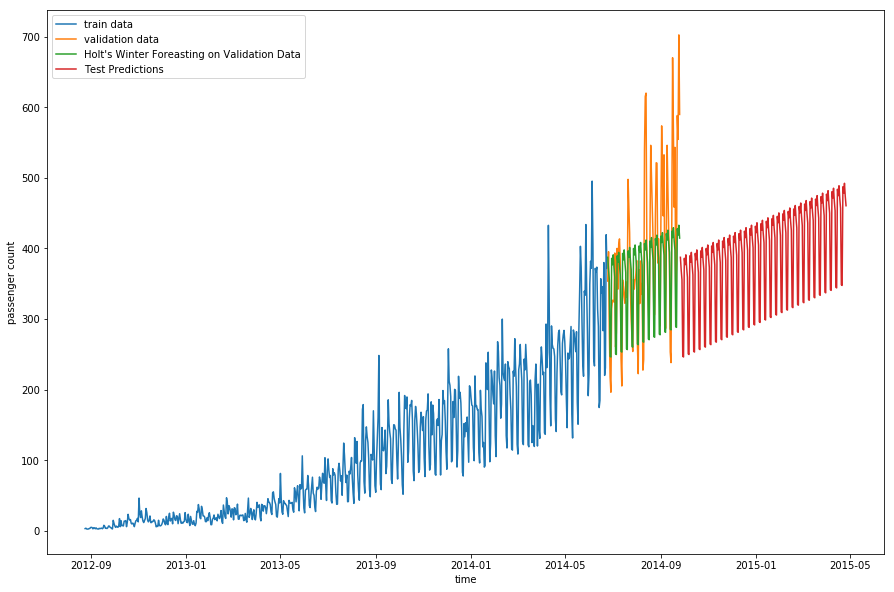

In [57]:
# Plotting everything

finalTestPredPlot = finalTestPred.copy()

finalTestPredPlot.set_index('Datetime',inplace=True)
finalTestPredPlot.drop('ID',axis=1,inplace=True)

finalTestPredPlot=finalTestPredPlot.resample('D').mean()

plt.figure(figsize = (15,10))
plt.plot(training['Count'])
plt.plot(validating['Count'])
plt.plot(pred['HWF'])
plt.plot(finalTestPredPlot['Count'])
plt.xlabel('time')
plt.ylabel('passenger count')
plt.legend(['train data','validation data',"Holt's Winter Foreasting on Validation Data",'Test Predictions'])

### Arima

In [58]:
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [59]:
test_stationarity(train_org['Count'])

Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [60]:
# test statistic < critical value (1%), series is stationary but weakly because the trend exists as observed 
# in previous plots

In [61]:
train_log = np.log(training['Count'])
valid_log = np.log(validating['Count'])

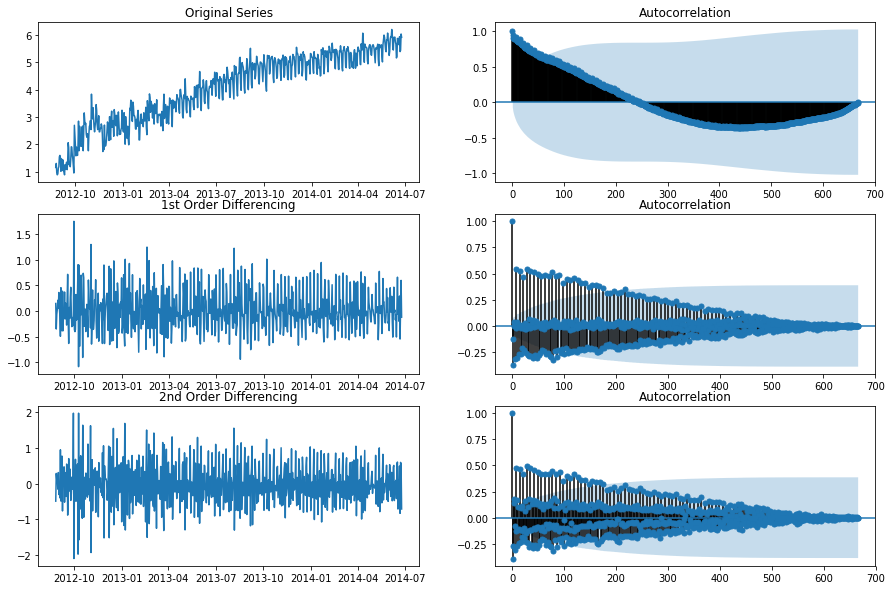

In [62]:
fig, axes = plt.subplots(3, 2, figsize=(15,10))
axes[0, 0].plot(train_log)
axes[0, 0].set_title('Original Series')
plot_acf(train_log, ax=axes[0, 1])
axes[1, 0].plot(train_log.diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(train_log.diff().dropna(), ax=axes[1, 1])
axes[2, 0].plot(train_log.diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train_log.diff().diff().dropna(), ax=axes[2, 1])
plt.show()

In [63]:
test_stationarity(train_log.diff().dropna())

Test Statistic                -8.237568e+00
p-value                        5.834049e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [64]:
# It can be observed that despite ADF test suggesting TS is stationary, ACF plot does not fall to 0 for original series, 
# hence differencing becomes necessary. We will chose d=1, as d=2 is clearly over-differencing it.

# Updated ADF test shows that series has now become strict stationary after 1st order differencing

In [65]:
rcParams['figure.figsize'] = 15, 10

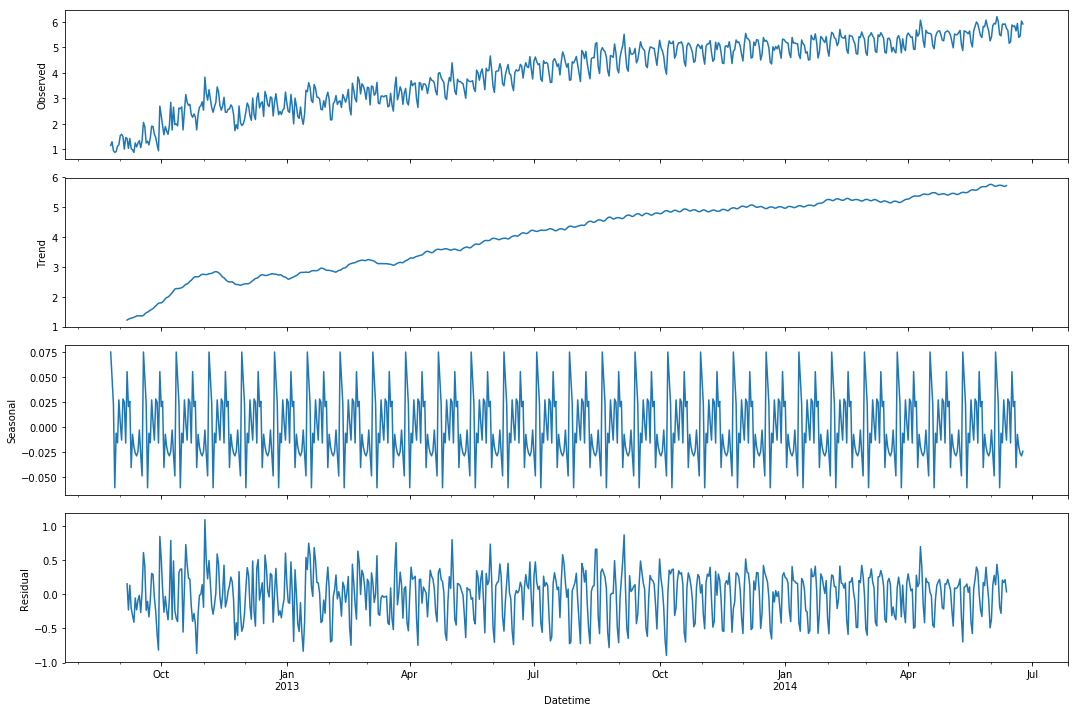

In [66]:
decomposition=sm.tsa.seasonal_decompose(train_log.dropna(),freq=24)
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid 

decomposition.plot()
plt.show()

In [67]:
train_org = train.copy()
test_org = test.copy()

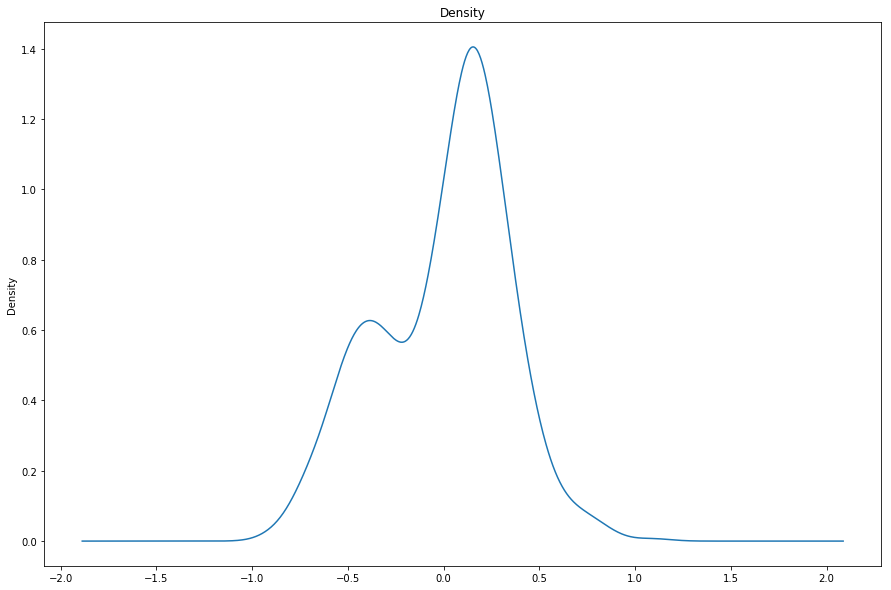

In [68]:
residual.plot(kind='kde', title='Density')

In [69]:
train_log_decompose = pd.DataFrame(residual) 
train_log_decompose['date'] = training.index 
train_log_decompose.set_index('date', inplace = True) 
train_log_decompose.dropna(inplace=True)

In [70]:
test_stationarity(train_log_decompose.Count)

Test Statistic                -7.822096e+00
p-value                        6.628321e-12
#Lags Used                     2.000000e+01
Number of Observations Used    6.240000e+02
Critical Value (1%)           -3.440873e+00
Critical Value (5%)           -2.866183e+00
Critical Value (10%)          -2.569243e+00
dtype: float64


In [71]:
lag_acf = acf(train_log.diff().dropna(), nlags=25) 
lag_pacf = pacf(train_log.diff().dropna(), nlags=25, method='ols')

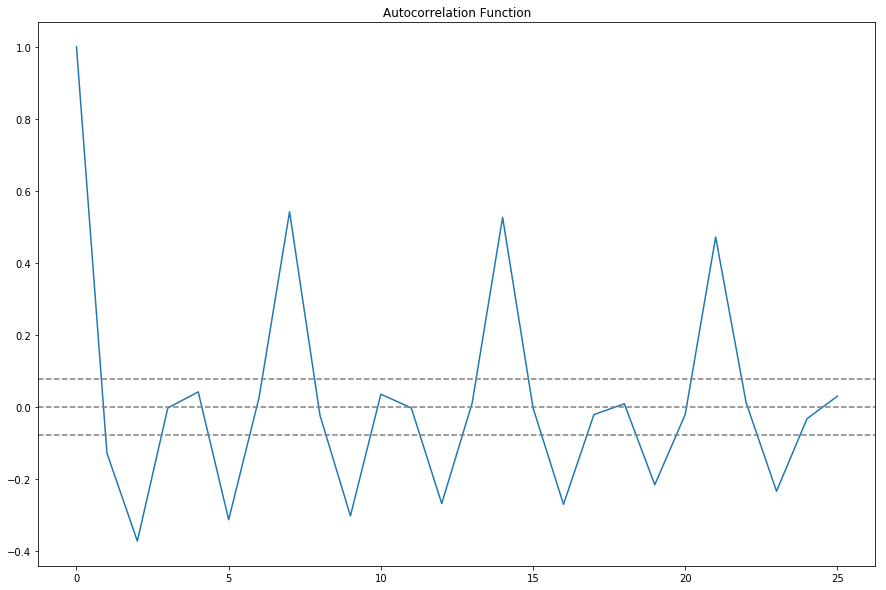

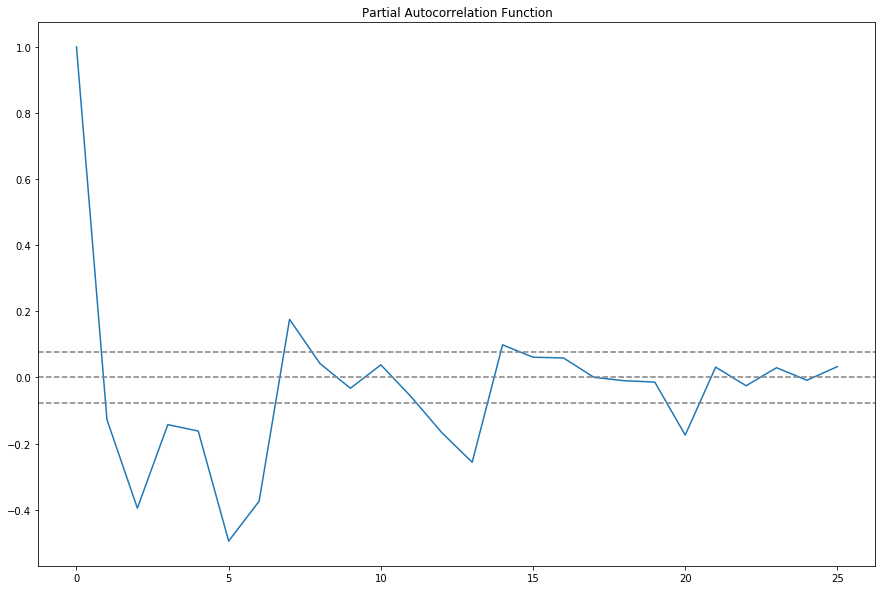

In [72]:
plt.plot(lag_acf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_decompose)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_decompose)),linestyle='--',color='gray') 
plt.title('Autocorrelation Function')  
plt.show()
plt.plot(lag_pacf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_decompose)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_decompose)),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function') 
plt.show()

In [73]:
# From PACF plot p=1 || From ACF plot q=1

C:\Users\User\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\User\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\User\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array i

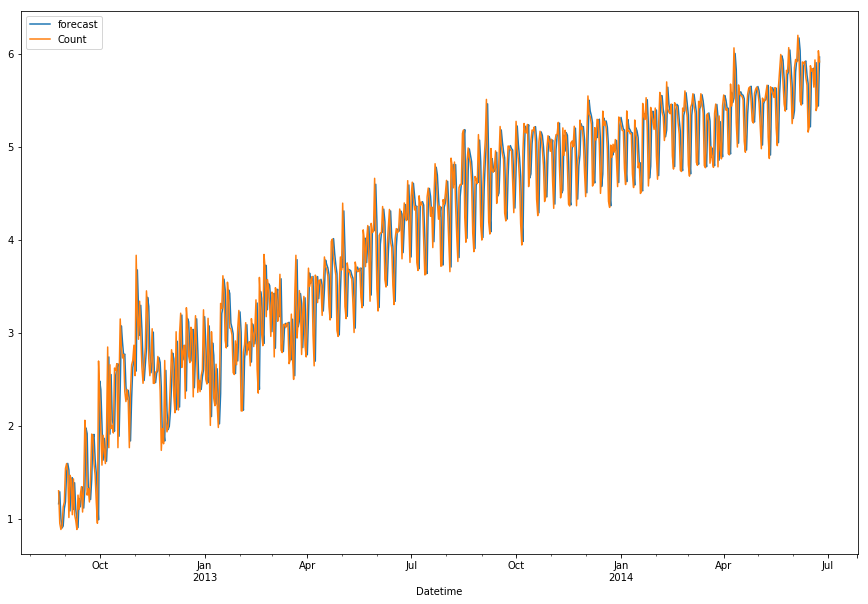

In [74]:
# AR Model
model = ARIMA(train_log, order=(1, 1, 0))

results_AR = model.fit(disp=-1)  
results_AR.plot_predict(dynamic=False)
plt.show()

In [75]:
ARfc,_,_ = results_AR.forecast(len(validating),alpha=0.05)

In [76]:
ARfc

array([5.94260677, 5.94768576, 5.95508099, 5.9621812 , 5.969319  ,
       5.976452  , 5.98358562, 5.99071916, 5.99785271, 6.00498626,
       6.0121198 , 6.01925335, 6.0263869 , 6.03352045, 6.04065399,
       6.04778754, 6.05492109, 6.06205463, 6.06918818, 6.07632173,
       6.08345528, 6.09058882, 6.09772237, 6.10485592, 6.11198947,
       6.11912301, 6.12625656, 6.13339011, 6.14052366, 6.1476572 ,
       6.15479075, 6.1619243 , 6.16905785, 6.17619139, 6.18332494,
       6.19045849, 6.19759204, 6.20472558, 6.21185913, 6.21899268,
       6.22612623, 6.23325977, 6.24039332, 6.24752687, 6.25466042,
       6.26179396, 6.26892751, 6.27606106, 6.28319461, 6.29032815,
       6.2974617 , 6.30459525, 6.3117288 , 6.31886234, 6.32599589,
       6.33312944, 6.34026299, 6.34739653, 6.35453008, 6.36166363,
       6.36879718, 6.37593072, 6.38306427, 6.39019782, 6.39733137,
       6.40446491, 6.41159846, 6.41873201, 6.42586556, 6.4329991 ,
       6.44013265, 6.4472662 , 6.45439975, 6.46153329, 6.46866

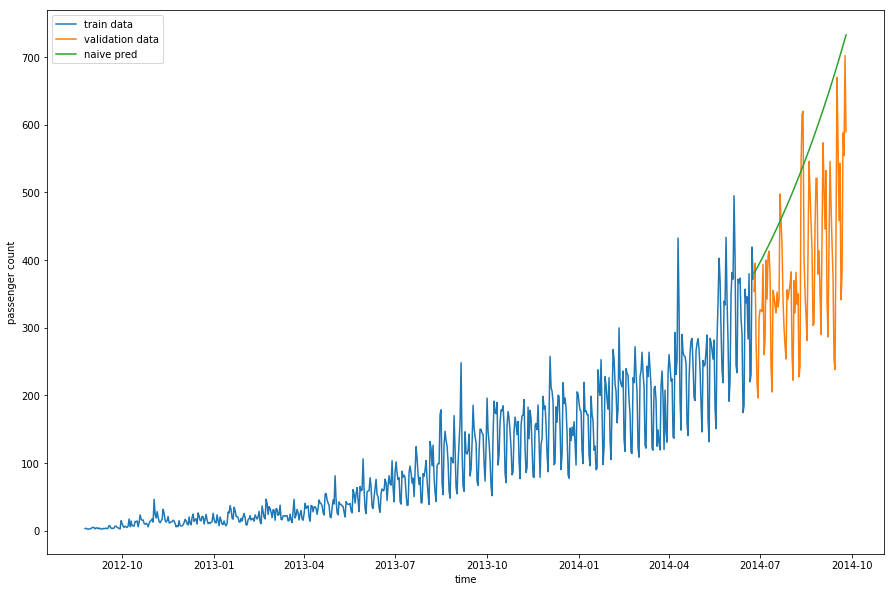

In [77]:
ARfc = np.exp(ARfc)

pred['AR'] = ARfc
plt.plot(training['Count'])
plt.plot(validating['Count'])
plt.plot(pred['AR'])
plt.xlabel('time')
plt.ylabel('passenger count')
plt.legend(['train data','validation data','naive pred'])

In [78]:
rmse = sqrt(mean_squared_error(validating.Count, ARfc)) 
print("RMSE SCORE:",rmse)

RMSE SCORE: 181.30110430073012


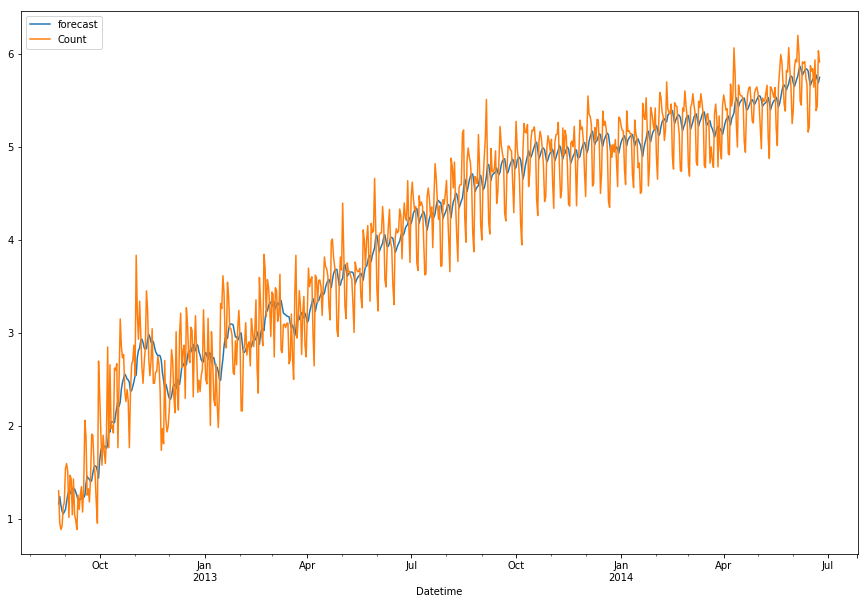

In [80]:
# MA model
MA_model = ARIMA(train_log, order=(0, 1, 1))

results_MA = MA_model.fit(disp=-1)  
results_MA.plot_predict(dynamic=False)
plt.show()

In [81]:
MAfc,_,_ = results_MA.forecast(len(validating))


np.exp(MAfc)

C:\Users\User\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


array([324.68967077, 326.95319337, 329.23249575, 331.52768794,
       333.83888069, 336.16618555, 338.50971485, 340.8695817 ,
       343.24589998, 345.63878439, 348.04835042, 350.47471435,
       352.91799329, 355.37830517, 357.85576872, 360.35050351,
       362.86262996, 365.39226929, 367.93954361, 370.50457584,
       373.08748979, 375.68841011, 378.30746234, 380.94477288,
       383.60046901, 386.2746789 , 388.96753163, 391.67915715,
       394.40968634, 397.15925098, 399.92798377, 402.71601835,
       405.52348927, 408.35053202, 411.19728306, 414.06387977,
       416.95046051, 419.85716458, 422.78413228, 425.73150488,
       428.69942461, 431.68803473, 434.69747947, 437.72790408,
       440.77945481, 443.85227894, 446.94652479, 450.06234167,
       453.19987998, 456.35929114, 459.54072764, 462.74434301,
       465.97029188, 469.21872995, 472.48981398, 475.78370186,
       479.10055256, 482.44052616, 485.80378385, 489.19048796,
       492.60080194, 496.03489039, 499.49291904, 502.97

In [82]:
rmse = sqrt(mean_squared_error(validating.Count, np.exp(MAfc))) 
print("RMSE SCORE:",rmse)

RMSE SCORE: 117.72977707902389


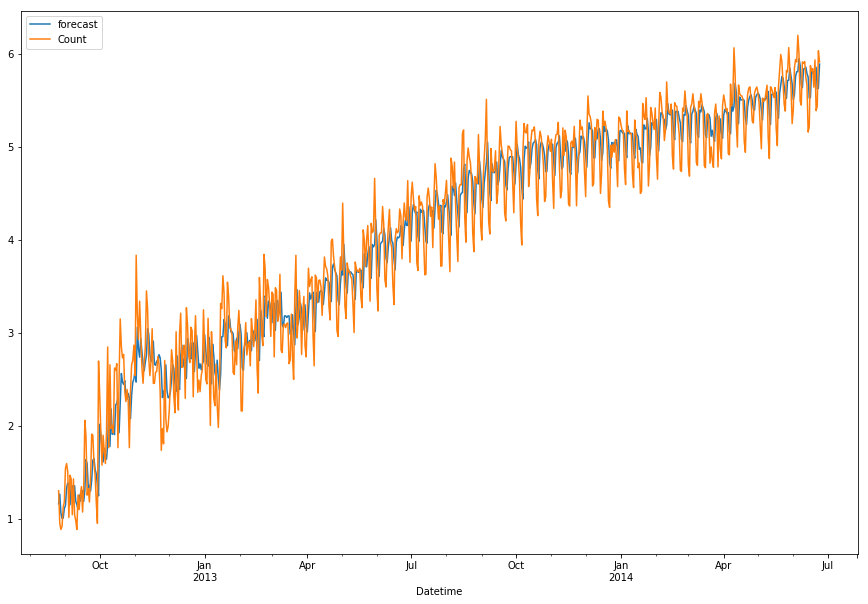

In [83]:
# ARIMA model
ARIMA_model = ARIMA(train_log, order=(1, 1, 1))  
results_ARIMA = ARIMA_model.fit(disp=-1)  
results_ARIMA.plot_predict(dynamic=False)
plt.show()

In [84]:
ARIMA_fc,_,_ = results_ARIMA.forecast(len(validating))

In [85]:
rmse = sqrt(mean_squared_error(validating.Count, np.exp(ARIMA_fc)))
print("RMSE SCORE:",rmse)

RMSE SCORE: 124.33132846266864


In [86]:
# Seasonal ARIMA
model=sm.tsa.statespace.SARIMAX(training.Count,order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [87]:
pred['SARIMAX']=model.forecast(len(validating))

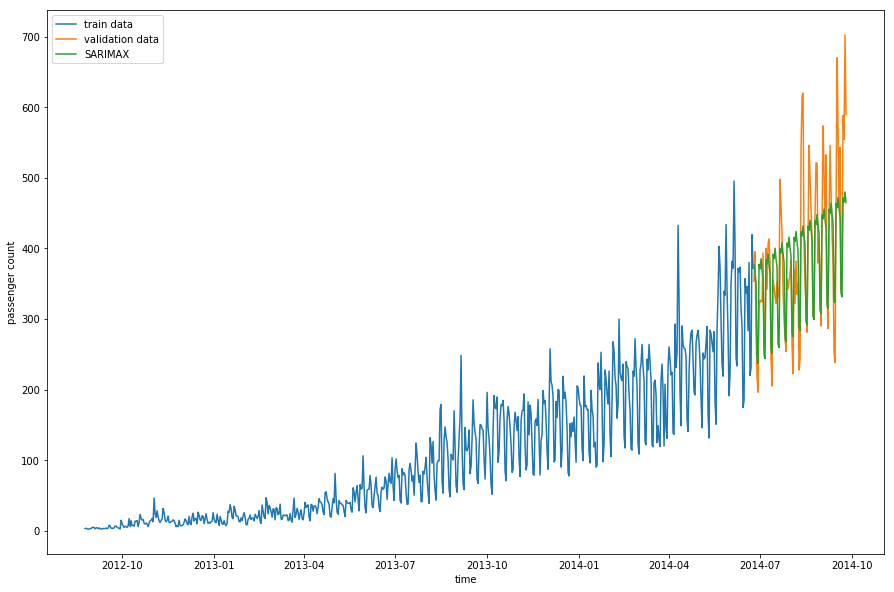

In [88]:
plt.plot(training['Count'])
plt.plot(validating['Count'])
plt.plot(pred['SARIMAX'])
plt.xlabel('time')
plt.ylabel('passenger count')
plt.legend(['train data','validation data','SARIMAX'])

In [89]:
rmse = sqrt(mean_squared_error(validating.Count, pred['SARIMAX'])) 
print("RMSE SCORE:",rmse)

RMSE SCORE: 70.05365452474315
